# Baseline Evaluation: DistilRoBERTa Emotion Model

This notebook evaluates `emotion-english-distilroberta-base` against the GoEmotions validation split mapped to 7 classes.

In [14]:
!pip install transformers torch datasets scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# Load the model — top-1 only, no need for all scores here
classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    device=-1
)
print("Model loaded.")

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: j-hartmann/emotion-english-distilroberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded.


In [16]:
# Label mapping from GoEmotions 28 → 7 classes
ORIGINAL_LABELS = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise','neutral'
]

LABEL_MAP_7 = {
    'anger':   ['anger','annoyance','disapproval'],
    'disgust': ['disgust'],
    'fear':    ['fear','nervousness'],
    'joy':     ['joy','amusement','approval','excitement','gratitude','love','optimism','pride','relief','admiration'],
    'neutral': ['neutral','realization'],
    'sadness': ['sadness','disappointment','grief','remorse','embarrassment'],
    'surprise':['surprise','confusion','curiosity','desire','caring']
}

# Reverse map: original label string → 7-class label
reverse_map = {}
for target, sources in LABEL_MAP_7.items():
    for s in sources:
        reverse_map[s] = target

CLASSES_7 = ['anger','disgust','fear','joy','neutral','sadness','surprise']
print("Mapping ready.")

Mapping ready.


In [17]:
# Load dataset and create validation split (raw config only has 'train')
ds = load_dataset("google-research-datasets/go_emotions", "raw")
df_all = ds["train"].to_pandas()

# Same 80/10/10 split as notebook 1
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
n = len(df_all)
df_val = df_all.iloc[int(n * 0.8):int(n * 0.9)].reset_index(drop=True)

# In raw config, each emotion is its own column (0/1) — filter to single-label rows
emotion_cols = [l for l in ORIGINAL_LABELS if l in df_val.columns]

samples = []
for _, row in df_val.iterrows():
    active = [e for e in emotion_cols if row[e] == 1]
    if len(active) == 1 and active[0] in reverse_map:
        samples.append({"text": row["text"], "true": reverse_map[active[0]]})

# Balanced sample (up to 200 per class)
from collections import defaultdict
per_class = defaultdict(list)
for s in samples:
    per_class[s["true"]].append(s)
balanced = []
for cls, items in per_class.items():
    balanced.extend(items[:200])

print(f"Evaluation samples: {len(balanced)}")
for cls in CLASSES_7:
    print(f"  {cls}: {len(per_class[cls][:200])}")

Evaluation samples: 1400
  anger: 200
  disgust: 200
  fear: 200
  joy: 200
  neutral: 200
  sadness: 200
  surprise: 200


In [18]:
# Run inference
texts  = [s["text"] for s in balanced]
truths = [s["true"] for s in balanced]

preds = []
for i in range(0, len(texts), 32):
    batch = texts[i:i+32]
    results = classifier(batch)
    for r in results:
        preds.append(r["label"].lower())
    if i % 320 == 0:
        print(f"  {i}/{len(texts)}")

print("Inference complete.")

  0/1400
  320/1400
  640/1400
  960/1400
  1280/1400
Inference complete.


In [19]:
# Metrics
acc = accuracy_score(truths, preds)
report = classification_report(truths, preds, labels=CLASSES_7, output_dict=True)

print(f"Accuracy: {acc:.3f}")
print(classification_report(truths, preds, labels=CLASSES_7))

# Save to artifacts
metrics_out = {
    "model": "j-hartmann/emotion-english-distilroberta-base",
    "overall_accuracy": round(acc, 4),
    "macro_f1": round(report["macro avg"]["f1-score"], 4),
    "per_class": {
        cls: {"precision": round(report[cls]["precision"], 4),
              "recall":    round(report[cls]["recall"], 4),
              "f1":        round(report[cls]["f1-score"], 4)}
        for cls in CLASSES_7
    }
}

with open("artifacts/metrics.json", "w") as f:
    json.dump(metrics_out, f, indent=2)
print("Saved to artifacts/metrics.json")

Accuracy: 0.440
              precision    recall  f1-score   support

       anger       0.34      0.24      0.28       200
     disgust       0.45      0.70      0.55       200
        fear       0.79      0.55      0.64       200
         joy       0.73      0.35      0.48       200
     neutral       0.27      0.59      0.37       200
     sadness       0.58      0.35      0.44       200
    surprise       0.39      0.29      0.33       200

    accuracy                           0.44      1400
   macro avg       0.51      0.44      0.44      1400
weighted avg       0.51      0.44      0.44      1400

Saved to artifacts/metrics.json


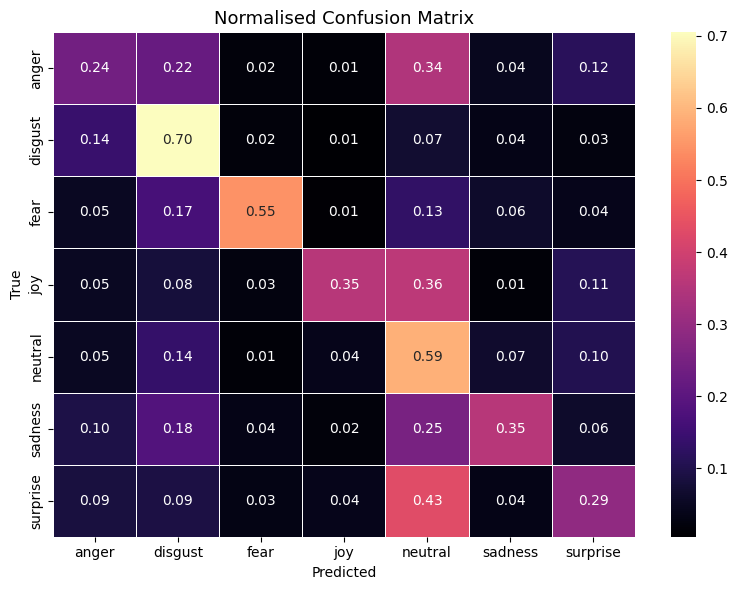

In [20]:
# Confusion matrix
cm = confusion_matrix(truths, preds, labels=CLASSES_7)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm / cm.sum(axis=1, keepdims=True),
    annot=True, fmt=".2f",
    xticklabels=CLASSES_7, yticklabels=CLASSES_7,
    cmap="magma", linewidths=0.5
)
plt.title("Normalised Confusion Matrix", fontsize=13)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("artifacts/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()